In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-12-31 10:05:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-31 10:05:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-31 10:05:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
import pandas as pd

glove_input_file = 'glove.6B.300d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

(400000, 300)

In [ ]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

In [ ]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 8.1 MB/s 


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from wordcloud import WordCloud
from textblob import Word
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
import torchmetrics
from torchmetrics.classification import BinaryROC,BinaryF1Score,BinaryRecall,BinaryPrecision,AUROC

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#Loading the dataset
df = pd.read_csv("./imdb-reviews.csv", sep='\t')
df.describe()

,rating
count,45008.000000
mean,5.481914
std,3.494293
min,1.000000
25%,2.000000
50%,7.000000
75%,9.000000
max,10.000000


In [ ]:
#Check for null values
#In this case there are no missing values
df.isnull().sum()

url       0
rating    0
review    0
dtype: int64

In [ ]:
#data preprocessing function
def preprocessing(review):
  review = review.lower()
  review = review.replace('http\S+|www.\S+|https\S+','') #removing urls
  review = review.replace('<br />', '') #removing <br>
  review = review.replace('...', '')
  review = word_tokenize(review) #tokenization
  review = " ".join(review)

  review = ' '.join([word for word in review.split() if word not in punctuation])
  review = ' '.join([word for word in review.split() if word not in stop_words])
  review = ' '.join([word for word in review.split() if not word.isdigit()])

  review = ' '. join([word for word in review.split() if "'" not in word])
  review = ' '. join([word for word in review.split() if "`" not in word])

  return "".join(Word(word).lemmatize() for word in review)

In [ ]:
#adding boolean sentiment column to the dataset
df['sentiment'] = df['rating'] >=7

In [ ]:
df['review'] = df['review'].apply(preprocessing)

In [ ]:
df = df.drop_duplicates('review')

In [ ]:
#splitting dataset into training and validation data
training_data = df.sample(frac=0.8)
validation_data = df.drop(training_data.index)

In [ ]:
x_train = pd.DataFrame(training_data, columns=[training_data.columns[-2]])
y_train = pd.DataFrame(training_data, columns=[training_data.columns[-1]])

In [ ]:
x_val = pd.DataFrame(validation_data, columns=[validation_data.columns[-2]])
y_val = pd.DataFrame(validation_data, columns=[validation_data.columns[-1]])

**Embeddings**

In [ ]:
def embeddings(x, y, model):
  result = []

  for j in range(len(x)):
    sum=0
    review = x.iloc[j].values[0]
    for i,w in enumerate(review.split()):
      try:
        sum += model[w]
      except KeyError:
        sum += model["0"]
    label = torch.tensor(int(y.iloc[j].values[0] == True)).float()
    result.append((sum/i, label))

  return result

In [ ]:
train = embeddings(x_train, y_train, model)
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

validation = embeddings(x_val, y_val, model)
valid_loader = torch.utils.data.DataLoader(validation, batch_size=128, shuffle=True)

**Defining FFNN**

In [ ]:
my_model = nn.Sequential(nn.Linear(300, 128),
                        nn.Linear(128, 64),
                        nn.Linear(64, 1),
                        nn.Sigmoid())
loss_func = nn.BCELoss()
#Define Hyperparameters
learning_rate = 1e-4
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)

**Training**

In [ ]:
losses = []
train_accuracy = []
val_accuracy = []
epochs = []
for epoch in range(50):
  batch_losses = []
  epochs.append(epoch)
  for x_batch, y_batch in train_loader:
    y_pred = my_model(x_batch)
    y_batch = y_batch.unsqueeze(1)

    loss = loss_func(y_pred, y_batch)
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    batch_losses.append(loss.item())
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
  losses.append(float(loss))

  correct = 0
  total = 0
  for review, sentiment in train_loader:

    output = my_model(review)
    pred = (output > 0.5).float()
    sentiment = sentiment.unsqueeze(1)
    correct += pred.eq(sentiment).sum()
    total += sentiment.shape[0]
  train_acc = correct.item() / total
  train_accuracy.append(train_acc)

  correct = 0
  total = 0
  for review, sentiment in valid_loader:

    output = my_model(review)
    pred = (output > 0.5).float()
    sentiment = sentiment.unsqueeze(1)
    correct += pred.eq(sentiment).sum()
    total += sentiment.shape[0]
  val_acc = correct.item() / total
  val_accuracy.append(val_acc)


  print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_loader):.5f}")

Epoch   0: Loss = 0.60903
Epoch   1: Loss = 0.44404
Epoch   2: Loss = 0.39907
Epoch   3: Loss = 0.38538
Epoch   4: Loss = 0.37937
Epoch   5: Loss = 0.37594
Epoch   6: Loss = 0.37425
Epoch   7: Loss = 0.37229
Epoch   8: Loss = 0.37145
Epoch   9: Loss = 0.37038
Epoch  10: Loss = 0.36978
Epoch  11: Loss = 0.36936
Epoch  12: Loss = 0.36858
Epoch  13: Loss = 0.36907
Epoch  14: Loss = 0.36829
Epoch  15: Loss = 0.36798
Epoch  16: Loss = 0.36816
Epoch  17: Loss = 0.36822
Epoch  18: Loss = 0.36719
Epoch  19: Loss = 0.36652
Epoch  20: Loss = 0.36653
Epoch  21: Loss = 0.36624
Epoch  22: Loss = 0.36730
Epoch  23: Loss = 0.36665
Epoch  24: Loss = 0.36647
Epoch  25: Loss = 0.36649
Epoch  26: Loss = 0.36628
Epoch  27: Loss = 0.36667
Epoch  28: Loss = 0.36681
Epoch  29: Loss = 0.36570
Epoch  30: Loss = 0.36613
Epoch  31: Loss = 0.36608
Epoch  32: Loss = 0.36607
Epoch  33: Loss = 0.36630
Epoch  34: Loss = 0.36595
Epoch  35: Loss = 0.36538
Epoch  36: Loss = 0.36571
Epoch  37: Loss = 0.36558
Epoch  38: L

**Accuracy**

In [ ]:
correct = 0
total = 0
for review, sentiment in train_loader:

  output = my_model(review)
  pred = (output > 0.5).float()
  sentiment = sentiment.unsqueeze(1)
  correct += pred.eq(sentiment).sum()
  total += sentiment.shape[0]
accuracy = correct.item() / total
print(accuracy)

0.8392477331243703


**Learning Curves**

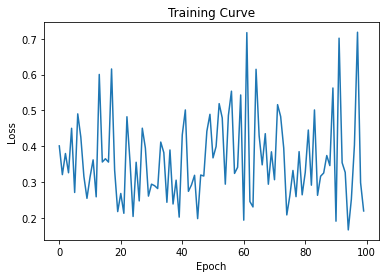

In [ ]:
# plotting
plt.title("Training Curve")
plt.plot(losses, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

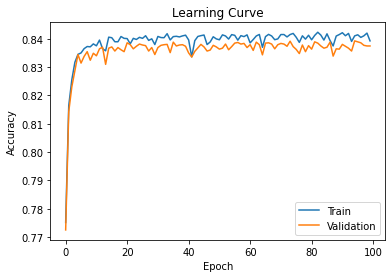

In [ ]:
plt.title("Learning Curve")
plt.plot(epochs, train_accuracy, label="Train")
plt.plot(epochs, val_accuracy, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

**F1 Score**

In [ ]:
predictions = []
sentiments = []
for review, sentiment in train_loader:
  output = my_model(review)
  pred = (output > 0.5).float()
  predictions.append(pred)
  sentiment = sentiment.unsqueeze(1)
  sentiments.append(sentiment)

predictions = torch.cat(predictions)
sentiments = torch.cat(sentiments)
f1_train = BinaryF1Score()
f1 = f1_train(predictions, sentiments)

In [ ]:
predictions = []
sentiments = []
for review, sentiment in valid_loader:
  output = my_model(review)
  pred = (output > 0.5).float()
  predictions.append(pred)
  sentiment = sentiment.unsqueeze(1)
  sentiments.append(sentiment)

predictions = torch.cat(predictions)
sentiments = torch.cat(sentiments)
f1_valid = BinaryF1Score()
f1 = f1_valid(predictions, sentiments)
print(f1.item())

0.841129720211029


**Recall**

In [ ]:
predictions = []
sentiments = []
for review, sentiment in train_loader:
  output = my_model(review)
  pred = (output > 0.5).float()
  predictions.append(pred)
  sentiment = sentiment.unsqueeze(1)
  sentiments.append(sentiment)

predictions = torch.cat(predictions)
sentiments = torch.cat(sentiments)
recall_train = BinaryRecall()
recall = recall_train(predictions, sentiments)
print(recall.item())

0.8542269468307495


In [ ]:
predictions = []
sentiments = []
for review, sentiment in valid_loader:
  output = my_model(review)
  pred = (output > 0.5).float()
  predictions.append(pred)
  sentiment = sentiment.unsqueeze(1)
  sentiments.append(sentiment)

predictions = torch.cat(predictions)
sentiments = torch.cat(sentiments)
recall_valid = BinaryRecall()
recall = recall_valid(predictions, sentiments)
print(recall.item())

0.8577857613563538


**Precision**

In [ ]:
predictions = []
sentiments = []
for review, sentiment in train_loader:
  output = my_model(review)
  pred = (output > 0.5).float()
  predictions.append(pred)
  sentiment = sentiment.unsqueeze(1)
  sentiments.append(sentiment)

predictions = torch.cat(predictions)
sentiments = torch.cat(sentiments)
precision_train = BinaryPrecision()
precision = precision_train(predictions, sentiments)
print(precision.item())

0.8339577317237854


In [ ]:
predictions = []
sentiments = []
for review, sentiment in valid_loader:
  output = my_model(review)
  pred = (output > 0.5).float()
  predictions.append(pred)
  sentiment = sentiment.unsqueeze(1)
  sentiments.append(sentiment)

predictions = torch.cat(predictions)
sentiments = torch.cat(sentiments)
precision_valid = BinaryPrecision()
precision = precision_valid(predictions, sentiments)
print(precision.item())

0.8251082301139832


**ROC Curves**

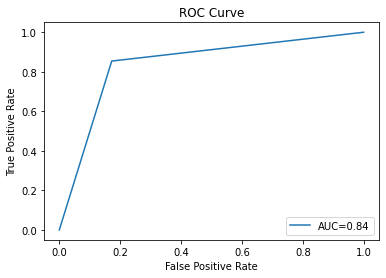

In [ ]:
predictions = []
sentiments = []
for review, sentiment in train_loader:
  output = my_model(review)
  pred = (output > 0.5).float()
  predictions.append(pred)
  sentiment = sentiment.unsqueeze(1)
  sentiments.append(sentiment)

predictions = torch.cat(predictions)
sentiments = torch.cat(sentiments)
roc = BinaryROC()
fpr, tpr, thresholds = roc(predictions, sentiments)
roc_auc = AUROC(task="binary")
auc = roc_auc(predictions, sentiments)
plt.plot(fpr,tpr,label='AUC=%0.2f'%auc)
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

**You can use the next part for testing**

In [ ]:
test_data = "place the test data set here"
x_test = pd.DataFrame(test_data, columns=[validation_data.columns[-2]])
y_test = pd.DataFrame(test_data, columns=[validation_data.columns[-1]])

test = embeddings(x_test, y_test, model)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

correct = 0
total = 0
for review, sentiment in test_loader:

  output = my_model(review)
  pred = (output > 0.5).float()
  sentiment = sentiment.unsqueeze(1)
  correct += pred.eq(sentiment).sum()
  total += sentiment.shape[0]
accuracy = correct.item() / total
print(accuracy)